#  **Описание задачи**

В данном задании нужно будет

- проанализировать АБ тест, проведенный на реальных пользователях Яндекса
- подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
- определить характер этих изменений и практическую значимость вводимого изменения
- понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)


Обращаем внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

#### Описание данных:

- userID: уникальный идентификатор пользователя
- browser: браузер, который использовал userID

- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
- n_clicks: количество кликов, которые пользоваль совершил за n_queries
- n_queries: количество запросов, который совершил userID, пользуясь браузером browser
- n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

## **Чтение файла**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
raw = pd.read_csv("ab_browser_test.csv") 
raw

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30
...,...,...,...,...,...,...
566129,603133,Browser #14,control,1,2,1
566130,603134,Browser #2,exp,4,2,0
566131,603135,Browser #4,control,0,1,1
566132,603136,Browser #4,control,2,3,1


### Задание 1 

Посчитаем, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлим до третьего знака после точки.

In [ ]:
data_exp = raw[raw['slot']  == 'exp'] # датасет, где группа = exp
data_control = raw[raw['slot']  == 'control'] # датасет, где группа = control

In [ ]:
percent = ((data_exp.n_clicks.sum() / data_control.n_clicks.sum())-1) * 100
print('Ответ 1: % отклонений =', percent )

Ответ 1: % отклонений = 1.6135689824415822


### Задание 2 

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого построим с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметим все верные утверждения.

In [ ]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data))) # вспомогательная функция для получения псевдоподвыборок
    samples = data[indices]
    return samples

# n_samples - количество выборок

In [ ]:
# считаем набор статистик

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Для бутстрэпа нужен формат np

In [ ]:
# считаем доверительный интервал для медианы (статистика)

np.random.seed(0)

exp_median_scores = list(map(np.median, get_bootstrap_samples(data_exp.n_clicks.values, 100)))
control_median_scores = list(map(np.median, get_bootstrap_samples(data_control.n_clicks.values, 100)))

print("95% confidence interval for the EXP median repair time:",  stat_intervals(exp_median_scores, 0.05))
print("95% confidence interval for the CONTROl median repair time:",  stat_intervals(control_median_scores, 0.05))

95% confidence interval for the EXP median repair time: [5. 5.]
95% confidence interval for the CONTROl median repair time: [4. 4.]


In [ ]:
# доверительный интервал для разности медиан

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(exp_median_scores, control_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-1. -1.]


In [ ]:
# считаем доверительный интервал для средних значений (статистика)

np.random.seed(0)

exp_mean_scores = list(map(np.mean, get_bootstrap_samples(data_exp.n_clicks.values, 100)))
control_mean_scores = list(map(np.mean, get_bootstrap_samples(data_control.n_clicks.values, 100)))

print("95% confidence interval for the EXP median repair time:",  stat_intervals(exp_mean_scores, 0.05))
print("95% confidence interval for the CONTROl median repair time:",  stat_intervals(control_mean_scores, 0.05))

95% confidence interval for the EXP median repair time: [11.51021077 11.65679008]
95% confidence interval for the CONTROl median repair time: [11.21278193 11.34695708]


In [ ]:
# доверительный интервал для разности среднего значения

delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(exp_mean_scores, control_mean_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for the difference between medians [-0.39441327 -0.20696841]


### Выводы:

1. 95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо

2. 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо



### Задание 3 

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

### Выводы:

Ответы:

1. Для проверки гипотезы о равенстве средних в данной задаче можно использовать только параметрические критерии, потому что непараметрические, как известно, с увеличением размера выборки могут давать непредсказуемые результаты в силу случайности в определении их нулевого распределения.

2. Используя центральную предельную теорему, мы можем заключить, что с ростом объема выборки любое исследуемое распределение, становится похожим на нормальное, а значит, учитывая большой объем нашей выборки, оптимальным критерием в нашей задаче будет z-критерий.

3. Гипотезу о равенстве средних между двумя выборками можно проверить с помощью построения доверительного интервала для среднего объединенной выборки, потому что в силу большого объема выборки этот интервал будет очень точным, и мы сможем надежно оценить необходимый доверительный интервал

4. Для проверки гипотезы о равенстве средних категорически нельзя использовать t-критерий Стьюдента ни при каком размере выборки, потому что количество кликов, которые мы исследуем, больше походят на распределение Пуассона, которое сильно отличается от нормального.

### Задание 4 

1. Получим из данных n_boot_samples псевдовыборок.
2. По каждой из этих выборок посчитаем среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
3. Для получившегося вектора средних значений из n_boot_samples построим q-q plot с помощью scipy.stats.probplot для нормального распределения
4. Для получившегося вектора сумм квадратов отклонения от выборочного среднего построим qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды

In [ ]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data))) # вспомогательная функция для получения псевдоподвыборок
    samples = data[indices]
    return samples

# n_samples - количество выборок

In [ ]:
# для бутстрепа используем np
np.random.seed (0)
n_boot_samples = 500

samples = get_bootstrap_samples (data_control.n_clicks.values,n_boot_samples)

In [ ]:
# по каждой выборке считаем среднее и сумму квадратов отклонений 

means = samples.mean(axis=1) # подсчет средних по каждому массиву 
delta = samples - means[:, np.newaxis] # отклонение  

# newaxis - каждый сэмпл в отдельное поле 
#x
#array([0, 1, 2])
#x[:, newaxis]
#array([[0],[1],[2]])

control_boot_chi_squared = np.sum(delta*delta,axis=1) # сумма квадратов отклонений от выборочных средних 

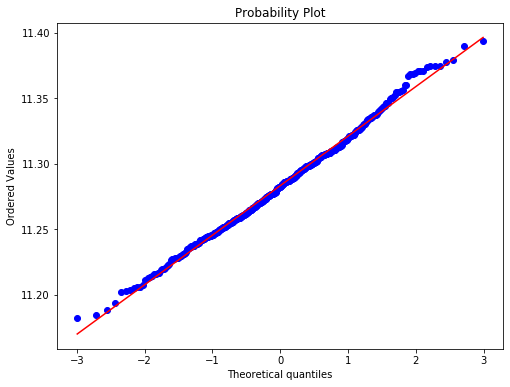

In [ ]:
# Для получившегося вектора средних значений из n_boot_samples постройте q-q plot 
#с помощью scipy.stats.probplot для нормального распределения


pylab.figure(figsize=(8,6))
scipy.stats.probplot(means, dist="norm", plot=pylab)
pylab.show()

Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды

 sparams=(n-1) - число степеней свободы 

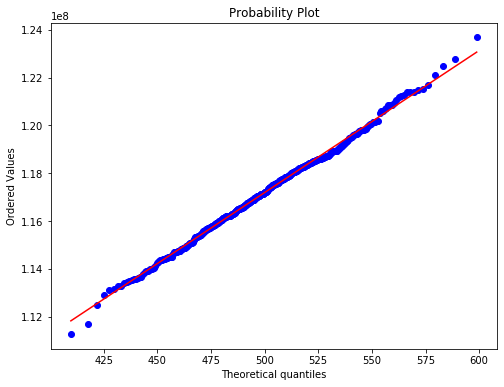

In [ ]:
pylab.figure(figsize=(8,6))
scipy.stats.probplot(control_boot_chi_squared, dist="chi2",sparams=(n_boot_samples-1), plot=pylab)
pylab.show()

### Задание 5 

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [ ]:
stats.mannwhitneyu(data_control.n_clicks, data_exp.n_clicks)

MannwhitneyuResult(statistic=38940590204.0, pvalue=3.1236179006848145e-75)

Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между двумя выборками

### Задание 6 

Проверим для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого применим для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с \alpha=0.05α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введем количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [ ]:
data_exp.browser.value_counts()

Browser #4     78152
Browser #22    71080
Browser #2     54944
Browser #14    44220
Browser #20    16931
Browser #17    16253
Name: browser, dtype: int64

In [ ]:
browser_names = ['Browser #4','Browser #22','Browser #2','Browser #14','Browser #20','Browser #17']

In [ ]:
stats.mannwhitneyu(a, b)[1]

0.40760617658454984

In [ ]:
browsers_data=[]

for i in browser_names:
    a = data_control[data_control['browser']  == i].n_clicks
    b = data_exp[data_exp['browser']  == i].n_clicks
    p_value = stats.mannwhitneyu(a, b)[1]
    browsers_data.append([i, p_value])



In [ ]:
browser_correlation = pd.DataFrame.from_records(browsers_data)
browser_correlation.columns = ['browser', 'p_value']

browser_correlation

,browser,p_value
0,Browser #4,0.407606
1,Browser #22,0.257406
2,Browser #2,0.027244
3,Browser #14,0.000000
4,Browser #20,0.453667
5,Browser #17,0.037401


In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests 

reject, p_corrected, a1, a2 = multipletests(browser_correlation.p_value, 
                                            alpha = 0.05, 
                                            method = 'bonferroni') 

In [ ]:
reject

array([False, False, False,  True, False, False])

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции
Ответ: 5 

### Задание 7

Для каждого браузера в каждой из двух групп (control и exp) посчитаем долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного анализа с показателем процента некликнутых запросов ? Отметим все верные утверждения.

In [ ]:
data_control

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
3,6,Browser #4,control,12,6,0
5,8,Browser #4,control,4,4,1
7,10,Browser #4,control,22,15,2
9,15,Browser #14,control,2,2,0
13,23,Browser #4,control,3,1,0
...,...,...,...,...,...,...
566124,603128,Browser #14,control,5,4,2
566128,603132,Browser #22,control,1,1,0
566129,603133,Browser #14,control,1,2,1
566131,603135,Browser #4,control,0,1,1


In [ ]:
n_queries_data=[]

for i in browser_names:
    control = ((data_control[data_control['browser']  == i].n_nonclk_queries.sum()) / (data_control[data_control['browser']  == i].n_queries.sum())) * 100
    exp = ((data_exp[data_exp['browser']  == i].n_nonclk_queries.sum()) / (data_exp[data_exp['browser']  == i].n_queries.sum())) * 100
    n_queries_data.append([i, control, exp])

In [ ]:
n_queries_data

[['Browser #4', 46.97092963514274, 45.14294190358467],
 ['Browser #22', 40.593976593513354, 39.85394721969546],
 ['Browser #2', 45.96274717919465, 44.982746948554706],
 ['Browser #14', 57.59041136008114, 43.755617361273295],
 ['Browser #20', 40.540484743383296, 38.97737648371716],
 ['Browser #17', 36.29936674628208, 36.93741284866483]]

Вывод:
    
   
С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно.